# Fatbox for Analogue Modelling - Fault extraction from PIV-derived strain data - tuto 4/6

This example describes how to extract a 2-D fault network from an analogue model simulating orthogonal continental rifting, as done in Tutorial B2, but using incremental strain data instead of elevation data.

The analog models are based on the study of Molnar et al. (2017)

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
!pip3 install earthpy
!pip install cv-algorithms
!pip install vtk

Mounted at /content/drive
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cv-algorithms: filename=cv_algorithms-1.1.1-cp311-cp311-manylinux_2_35_x86_64.whl size=40946 sha256=b6d15da10246b68f224e38d48b94e5d26c4db22d614cc0670d0c39a4a1bebc13
  Stored in directory: /root/.cache/pip/wheels/6d/fc/8d/7dc6a93ee79ff25fd3491eac76e255cca24893bb3d5f3cc150
Successfully built cv-algorithms
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 MB 7.6 MB/s eta 0:00:00


Now we can load the python packages that we need:

In [4]:
import numpy as np
import networkx as nx
import cv2
import pickletools

import copy

import math
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.signal import fftconvolve, savgol_filter

from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

from pathlib import Path #The gestion of Path with pathlib allows for universal use.
import os
path_folder=Path('/content/drive/MyDrive/Fatbox')
path_folder=path_folder/'modules'
#print(path_folder) #make sure path_folder = '/Fatbox_fault_analysis_toolbox/modules'
os.chdir(path_folder) # make modules as working directory
#type pwd in console and make sure it is '/Fatbox_fault_analysis_toolbox/modules'

import preprocessing
import metrics
import plots
import utils
import structural_analysis
import edits

## Load data
In this case, we have a data set consisting of 15 incremental strain numpy arrays obtained from cleaning and cropping the data exported from the PIV software

In [7]:
path_input=Path('/content/drive/MyDrive/Fatbox/tutorials/analog/data_analog')

incr_str = [] #all incremental strain arrays will be stored here

for n in range(1,16): #because there are 15 arrays
  data = np.load((path_input/str('is' + str(n) + '.npy')))
  incr_str.append(data)

#simple step to get rows and columns in case it is needed for visualization purposes later
straindata = incr_str[0]
rows,columns = straindata.shape


## 1. Fault extraction

Plot raw to see what are we looking at, for all timesteps:

In [8]:
def f(time):
    plt.figure(figsize=(6,10)) #set up plot
    timestep = incr_str[time] #get the strain values for each timestep
    plt.title('Incremental strain - Raw')
    plt.imshow(timestep, cmap='inferno', vmin=0, vmax=5)
    plt.colorbar()

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

Before moving on to the image analysis and fault detection, we can apply a Gaussian blur filter to smooth the data a little bit in order to get better results (especially considering that PIV data is usually exported with certain irregularities) by reducing its noise:

In [9]:
def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    return fftconvolve(padded_array, g, mode='valid')

In [10]:
blurfact = 10 #the higher this number is, the more we will smooth the data

blur_is = [] #create a list where blurred incremental strain arrays will be stored

for n in range(0,15): #because there are 14 arrays
  bluris = gaussian_blur(incr_str[n], blurfact)
  blur_is.append(bluris)

def f(time):
    rawis = incr_str[time] #get the raw strain values for each timestep
    bluris = blur_is[time] #get the smoothed strain values for each timestep

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) #set up plot

    axs[0].set_title('Incremental strain - Raw')
    axs[0].imshow(rawis, cmap='inferno', vmin=0, vmax=5)

    axs[1].set_title('Incremental strain - Smoothed')
    axs[1].imshow(bluris, cmap='inferno', vmin=0, vmax=5)

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

Next we want to separate the faults from the background using a pre-defined threshold:

In [11]:
str_threshold = 2.6 #fixed threshold, try with adaptive/other ways too!

def f(time):
    plt.figure(figsize=(5,10)) #set up plot
    #straindata = incr_str[time] #get the strain values for each timestep
    straindata = blur_is[time] #get the strain values for each timestep
    threshold = preprocessing.simple_threshold_binary(straindata, str_threshold)
    plt.title('Incremental strain - Threshold: ' + str(str_threshold))
    plt.imshow(threshold, cmap='Greys')

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

Next step is to reduce the areas above the threshold to lines using a skeletonize algorithm:

In [12]:
def f(time):
    plt.figure(figsize=(5,10)) #set up plot
    #straindata = incr_str[time] #get the strain values for each timestep
    straindata = blur_is[time] #get the strain values for each timestep
    threshold = preprocessing.simple_threshold_binary(straindata, str_threshold)
    skeleton = preprocessing.skeleton_guo_hall(threshold)
    plt.title('Skeletonized - Threshold: ' + str(str_threshold) + ' %')
    plt.imshow(skeleton, cmap='Greys')

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

Up to this point, we are at an analogous step to the canny edge detection stage when working with elevation data [Tutorial B1 and Tutorial B2].

From here onward, we can apply a similar loop that converts all the skeletonized images using the pre-defined strain threshold into fault networks:

In [15]:
# First we need to define a set of auxiliary functions to calculate strike difference,
# which is used as a parameter to clean the network

# function 1
def mystrike(x1, y1, x2, y2):
  if (x2-x1)<0:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1))) + 360
  else:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1)))

  #Scale to [0, 180]
  if strike<=180:
    return strike
  else:
    return strike - 180

#function 2
def calculate_mystrike(G, non):
    """ Compute strike of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing edges with 'strike' attribute
    """

    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'

    for node in tqdm(G, desc='Calculate mystrike'):


        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)


        neighbors = sorted(neighbors.items())

        first = neighbors[0][0]
        last = neighbors[-1][0]

        # print(node)
        # print(neighbors)
        # print(first, last)



        x1 = G.nodes[first]['pos'][0]
        y1 = G.nodes[first]['pos'][1]

        x2 = G.nodes[last]['pos'][0]
        y2 = G.nodes[last]['pos'][1]


        G.nodes[node]['strike'] = mystrike(x1, y1, x2, y2)


    for edge in G.edges:
        G.edges[edge]['strike'] = (G.nodes[edge[0]]['strike'] + G.nodes[edge[0]]['strike'])/2

    return G

#function 3
def calculate_diff_strike(G, non):
    """ Compute strike difference between nodes of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing nodes with 'strike' attribute
    """


    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'


    for node in G:

        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)
        #print(neighbors)
        #print(len(neighbors))
        strikes = [G.nodes[node]['strike'] for node in neighbors.keys()]
        #print(strikes)
        #print(len(strikes))
        if len(neighbors) > 1:
          G.nodes[node]['strike_diff'] = np.max(np.diff(strikes))
        else:
          G.nodes[node]['strike_diff'] = np.nan


    return G

# function 4

def remove_nodes_between(G, attribute, low, high):
    """ Remove node with attribute between two values

    Parameters
    ----------
    G : nx.graph
        Graph
    attribute : str
        Attribute
    low : float
        lower value
    high : float
        higher value

    Returns
    -------
    G : nx.graph
        Graph
    """
    removals = []
    # Assertions
    assert isinstance(G, nx.Graph), "G is not a NetworkX graph"

    # Calculation
    for node in G.nodes:
        if G.nodes[node][attribute] >= low and G.nodes[node][attribute] <= high:
            removals.append(node)

    G.remove_nodes_from(removals)

    return G

In [17]:
G_is = [] #all graphs derived from incremental strain arrays will be stored here

non1 = 2 #number of neighbour edges taken into account to calculate edge strike (original =2)
non2 = 6 #number of neighbour edges taken into account to calculate edge strike difference (original =12)
lowangle = 60 #lower angle value (original =60)
highangle = 120 #upper angle value (original =120)

f_thr = 40 #fault length threshold

for n in range(0,15):

  print('')
  print('Timestep ' + str(n+1))
  #threshold = simple_threshold_binary(blur_is[n], str_threshold) #step 1 of 3, grab incremental strain numpy array, apply threshold value
  threshold = preprocessing.simple_threshold_binary(incr_str[n], str_threshold) #step 1 of 3, grab incremental strain numpy array, apply threshold value
  skeleton = preprocessing.skeleton_guo_hall(threshold) #step 2 of 3, skeletonize the image based on the threshold value
  #points = array_to_points(skeleton) #step 3 of 3, convert lines to points
  ret, markers = cv2.connectedComponents(skeleton) #step 3a of 3, get connected components from the skeletonised image
  points = preprocessing.array_to_points(skeleton) #step 3b of 3, convert lines to points

  G = nx.Graph() #create Graph from the skeletonised result

  node = 0
  for comp in range(1,ret):
    points = np.transpose(np.vstack((np.where(markers==comp))))

    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1

  for comp in range(1,ret):

    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)

    for o in range(len(points)):

        for m in range(len(points)):
            if dm[o,m]<1.5 and o != m:
                G.add_edge(nodes[o],nodes[m])

  for node in list(G.nodes()):
   if G.degree(node) == 3 or G.degree(node) == 4 or G.degree(node) == 5: #remove nodes with 3, 4, 5 edges
       edges = list(G.edges(node))
       G.add_edge(edges[0][1], edges[1][1])
       G.remove_node(node)

  G = calculate_mystrike(G, non1) #we calculate the strike for each node/edge
  G = calculate_diff_strike(G, non2) #we calculate the difference in strike between one edge and the neighbour edge at distance=non2 (number of neighbours)
  G = remove_nodes_between(G, attribute='strike_diff', low=lowangle, high=highangle) #remove all nodes that have a strike difference between 'low' and 'high'

  G = edits.label_components(G)

  for node in G:
    G.nodes[node]['fault'] = G.nodes[node]['component'] #make component ID and fault ID match

  def get_fault_labels(G):
    labels=set()
    for nodex in G:
        labels.add(G.nodes[nodex]['fault'])
    return sorted(list(labels))

  fault_labels = get_fault_labels(G)

  f_len = metrics.calculate_fault_lengths(G, mode='get') #get fault lengths for cleaning them by length in the following step
  f_id_clean = np.argwhere(f_len<f_thr) #get faults with a length smaller than the threshold

  #print a little summary of each timestep to see how things are working out
  print("Total number of faults: " + str(len(f_len)))
  print("Faults shorter than " + str(f_thr) + " : " + str(len(f_id_clean)))
  print("Remaining faults: " + str(len(f_len)-len(f_id_clean)))

  for e in range(len(f_id_clean)): #number of times we are going to loop this, which is the number of faults that meet our condition
   fid = f_id_clean.item(e) #get a temporary variable, fid = fault id
   for node in G.copy():
     if G.nodes[node]['fault'] == fid: #if the fault id's match
       G.remove_node(node) #remove all nodes associated to that fault id

  G = edits.label_components(G)

  G_is.append(G) #after finishing this loop, adds the new graph to the G_is list

def f(time):
    H = G_is[time] #grab graph corresponding to each timestep
    H = edits.label_components(H) #first we create the labels of the components in our graph
    bluris = blur_is[time]

    fig, axs = plt.subplots(1, 2, figsize=(8,8), sharex=True) #set up plot

    axs[0].imshow(bluris, cmap='inferno', vmin=0, vmax=5)
    axs[0].set_ylim([1000,0])
    axs[0].set_xlim([0,400])
    axs[0].set_title('Incremental strain')

    plots.plot_components(H, node_size=1, ax=axs[1], label=True) #then we plot them
    axs[1].set_ylim([1000,0])
    axs[1].set_xlim([0,400])
    axs[1].set_title('Clean network')

    plt.tight_layout()
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot


Timestep 1


Calculate mystrike: 100%|██████████| 291/291 [00:00<00:00, 61593.79it/s]

Total number of faults: 22
Faults shorter than 40 : 19
Remaining faults: 3

Timestep 2



Calculate mystrike: 100%|██████████| 665/665 [00:00<00:00, 87493.72it/s]


Total number of faults: 60
Faults shorter than 40 : 56
Remaining faults: 4

Timestep 3


Calculate mystrike: 100%|██████████| 1478/1478 [00:00<00:00, 95411.65it/s]


Total number of faults: 85
Faults shorter than 40 : 75
Remaining faults: 10

Timestep 4


Calculate mystrike: 100%|██████████| 2636/2636 [00:00<00:00, 95621.89it/s]


Total number of faults: 83
Faults shorter than 40 : 65
Remaining faults: 18

Timestep 5


Calculate mystrike: 100%|██████████| 3244/3244 [00:00<00:00, 59618.28it/s]


Total number of faults: 97
Faults shorter than 40 : 83
Remaining faults: 14

Timestep 6


Calculate mystrike: 100%|██████████| 4126/4126 [00:00<00:00, 103112.61it/s]


Total number of faults: 92
Faults shorter than 40 : 77
Remaining faults: 15

Timestep 7


Calculate mystrike: 100%|██████████| 4588/4588 [00:00<00:00, 63633.07it/s]


Total number of faults: 97
Faults shorter than 40 : 80
Remaining faults: 17

Timestep 8


Calculate mystrike: 100%|██████████| 5155/5155 [00:00<00:00, 104391.84it/s]


Total number of faults: 106
Faults shorter than 40 : 87
Remaining faults: 19

Timestep 9


Calculate mystrike: 100%|██████████| 5554/5554 [00:00<00:00, 107807.06it/s]


Total number of faults: 100
Faults shorter than 40 : 76
Remaining faults: 24

Timestep 10


Calculate mystrike: 100%|██████████| 6016/6016 [00:00<00:00, 63787.66it/s]


Total number of faults: 133
Faults shorter than 40 : 105
Remaining faults: 28

Timestep 11


Calculate mystrike: 100%|██████████| 5816/5816 [00:00<00:00, 98991.07it/s]


Total number of faults: 103
Faults shorter than 40 : 80
Remaining faults: 23

Timestep 12


Calculate mystrike: 100%|██████████| 6112/6112 [00:00<00:00, 96723.83it/s]


Total number of faults: 105
Faults shorter than 40 : 83
Remaining faults: 22

Timestep 13


Calculate mystrike: 100%|██████████| 6227/6227 [00:00<00:00, 56422.65it/s]


Total number of faults: 122
Faults shorter than 40 : 99
Remaining faults: 23

Timestep 14


Calculate mystrike: 100%|██████████| 6241/6241 [00:00<00:00, 58076.64it/s]


Total number of faults: 128
Faults shorter than 40 : 103
Remaining faults: 25

Timestep 15


Calculate mystrike: 100%|██████████| 6201/6201 [00:00<00:00, 107489.36it/s]


Total number of faults: 128
Faults shorter than 40 : 104
Remaining faults: 24


interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

**Doesn't look bad!**

Although we haven't done the fault correlation between time steps yet. Let's do the same thing we did in Tutorial B2:

In [18]:
def get_nodes(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set


def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))


def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the
    # minimum radius R

    # Get labels and nodes
    fault_labels_0 = get_fault_labels(G_0)
    fault_labels_1 = get_fault_labels(G_1)

    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1)

    # Compute similarities
    smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
    smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))

    for n in tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
        for m in range(len(fault_labels_1)):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])

    # Determine correlations
    correlations = set()
    for n in tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
        for m in range(len(fault_labels_1)):
            if smf[n,m] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if smb[m,n] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))

    return correlations, smf, smb

In [19]:
def G_to_pts(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set

def is_A_in_B(set_A, set_B, R):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      if np.mean(np.min(distances, axis=1)) > R:
          return False
      else:
          return True

And let's relabel the faults in time step 1 to match time step 0:

In [20]:
def relabel(G_1, correlations):

    # A function, which relabels G_1 using the correlations
    for node in G_1:
        G_1.nodes[node]['correlated']=0

    lengths = [metrics.total_length(metrics.get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
    lengths, correlations = zip(*sorted(zip(lengths, correlations)))


    for node in G_1:
        for correlation in correlations:
            if G_1.nodes[node]['component'] == correlation[1]:
                G_1.nodes[node]['fault'] = correlation[0]
                G_1.nodes[node]['correlated'] = 1

    max_comp = max(get_fault_labels(G_1))

    G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])
    for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))):
        for n in cc:
            G_1.nodes[n]['fault'] = label+max_comp+1

    return G_1

We apply the fault correlation for all timesteps in our dataset:

In [21]:
R = 10 #Modify this value and check best results

for n, time in enumerate(range(0,len(G_is)-1)): #loop through all timesteps, stop one before the end because it would create a size error
  print('Timesteps ' + str(time+1) + '-' + str(time+2) + '/16')
  G_0 = G_is[time]
  G_1 = G_is[time+1]

  if n == 0: # Only do this for the first correlation
    for node in G_0:
      G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

  for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

  correlations, smf, smb = correlation_slow(G_0, G_1, R=R)
  G_1 = relabel(G_1, correlations)

  G_is[time+1] = G_1

Timesteps 1-2/16


   Find correlations: 100%|██████████| 3/3 [00:00<00:00, 13766.86it/s]


Timesteps 2-3/16


   Find correlations: 100%|██████████| 4/4 [00:00<00:00, 24929.00it/s]


Timesteps 3-4/16


   Find correlations: 100%|██████████| 10/10 [00:00<00:00, 44810.94it/s]


Timesteps 4-5/16


   Find correlations: 100%|██████████| 18/18 [00:00<00:00, 59400.06it/s]


Timesteps 5-6/16


   Find correlations: 100%|██████████| 14/14 [00:00<00:00, 39595.59it/s]


Timesteps 6-7/16


   Find correlations: 100%|██████████| 13/13 [00:00<00:00, 28019.50it/s]


Timesteps 7-8/16


   Find correlations: 100%|██████████| 15/15 [00:00<00:00, 34285.86it/s]


Timesteps 8-9/16


   Find correlations: 100%|██████████| 17/17 [00:00<00:00, 30458.42it/s]


Timesteps 9-10/16


   Find correlations: 100%|██████████| 19/19 [00:00<00:00, 38779.45it/s]


Timesteps 10-11/16


   Find correlations: 100%|██████████| 16/16 [00:00<00:00, 31610.39it/s]


Timesteps 11-12/16


   Find correlations: 100%|██████████| 16/16 [00:00<00:00, 43073.73it/s]


Timesteps 12-13/16


   Find correlations: 100%|██████████| 15/15 [00:00<00:00, 31022.96it/s]


Timesteps 13-14/16


   Find correlations: 100%|██████████| 14/14 [00:00<00:00, 27763.71it/s]


Timesteps 14-15/16


   Find correlations: 100%|██████████| 13/13 [00:00<00:00, 26064.03it/s]


If we plot all the timesteps again, we should see matching fault IDs over time:

In [22]:
def f(time):
    G = G_is[time] #grab graph corresponding to each timestep

    fig, axs = plt.subplots(1,1, figsize=(4,10)) #set up plot

    plots.plot_faults(G, node_size=1, ax=axs, label=True)
    axs.set_title('Correlated faults')
    axs.set_ylim([1000,0])
    axs.set_xlim([0,400])

    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=14, step=1, layout=Layout(width='700px')))
output = interactive_plot.children[-1]
output.layout.width = '800px'
interactive_plot

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='700px'), max=14), Output(lay…

## Bonus: visualizing fault networks with attributes

If we take advantage of the versatility of working with a network (graph) that stores attribute data into the nodes and edges, we can go a step further and visualize our fault network with attribute data. In this example, incremental strain.

Let's start by having a look 'inside' the nodes:

In [23]:
time = 12 #randomly selected one of the timesteps

H = G_is[time]
print(H.nodes)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

Okay, nothing special here, just a list of the nodes. Let's pick out one:

In [24]:
print(H.nodes[24])

{'pos': (np.int64(112), np.int64(0)), 'component': 0, 'strike': 0.0, 'strike_diff': np.float64(161.56505117707798), 'fault': 27, 'correlated': 1}


Alright, we can see the position of the node and the component it belongs to. Let's say we want to give it an extra property, e.g. the strain rate at its location:

In [25]:
H.nodes[24]['straindata'] = straindata[int(H.nodes[24]['pos'][0]), int(H.nodes[24]['pos'][1])]

In [26]:
print(H.nodes[24])

{'pos': (np.int64(112), np.int64(0)), 'component': 0, 'strike': 0.0, 'strike_diff': np.float64(161.56505117707798), 'fault': 27, 'correlated': 1, 'straindata': np.float64(0.25027874683765244)}


Nice! Let's do that for all nodes:

In [27]:
for node in H.nodes:
  H.nodes[node]['straindata'] = straindata[int(H.nodes[node]['pos'][1]), int(H.nodes[node]['pos'][0])]

and plot it:

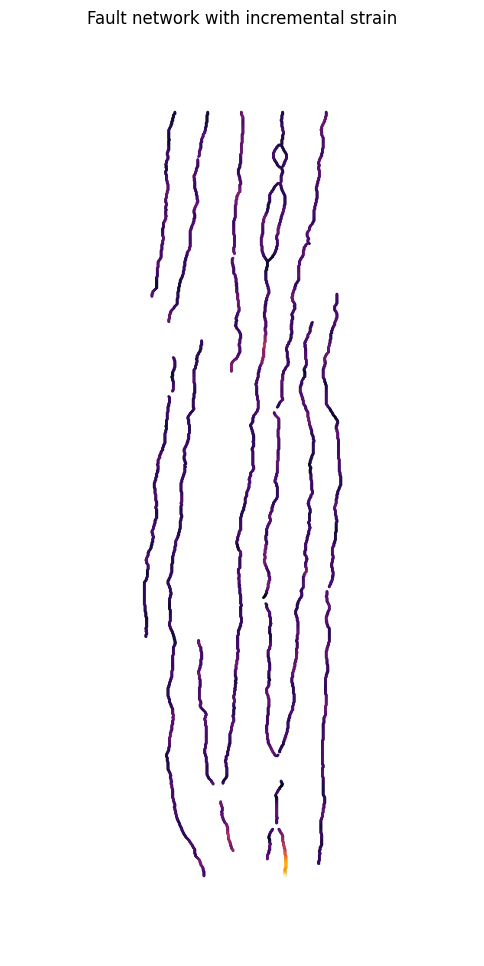

In [28]:
fig, ax = plt.subplots(figsize=(6,12))

ax.set_title('Fault network with incremental strain')
nx.draw(H,
        pos=nx.get_node_attributes(H, 'pos'),
        node_color = np.array([H.nodes[node]['straindata'] for node in H.nodes]),
        node_size=1,
        cmap=plt.cm.inferno,
        ax=ax)
ax.invert_yaxis()
ax.axis('equal')
plt.show()

In [29]:
# #store fault network for using in Tutorial B5
import pickle
save_path = Path('/content/drive/MyDrive/Fatbox/tutorials/analog')

save_graph=False
if save_graph==True:
    # save graph object to file
    loc=(save_path/'array') #do not modify, this is a shortcut

    with open((loc/'is_graphs.pkl'), 'wb') as f:
      pickle.dump(G_is, f) #, protocol=pickle.HIGHEST_PROTOCOL)
